In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

Extent       Date
0    1090625.815 1979-01-01
1    1157634.866 1979-02-01
2    1299583.477 1979-03-01
3    1137194.680 1979-04-01
4     983083.453 1979-05-01
..           ...        ...
533   781460.891 2023-06-01
534   331845.048 2023-07-01
535    99334.625 2023-08-01
536    49359.723 2023-09-01
537    85693.282 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 23s 273ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738 - val_loss: 0.1465 - val_root_mean_squared_error: 0.3827
Epoch 2/50
53/53 [==============================] - 15s 293ms/step - loss: 0.1122 - root_mean_squared_error: 0.3350 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2568
Epoch 3/50
53/53 [==============================] - 13s 251ms/step - loss: 0.0686 - root_mean_squared_error: 0.2619 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2504
Epoch 4/50
53/53 [==============================] - 14s 260ms/step - loss: 0.0655 - root_mean_squared_error: 0.2559 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2464
Epoch 5/50
53/53 [==============================] - 20s 391ms/step - loss: 0.0599 - root_mean_squared_error: 0.2447 - val_loss: 0.0529 - val_root_mean_squared_error: 0.2301
Epoch 6/50
53/53 [==============================] - 13s 240ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0456 

Epoch 30/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 31/50
53/53 [==============================] - 2s 29ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 32/50
53/53 [==============================] - 13s 254ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 33/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605
Epoch 34/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570
Epoch 35/50
53/53 [==============================] - 13s 246ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0030 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.40570025841395 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

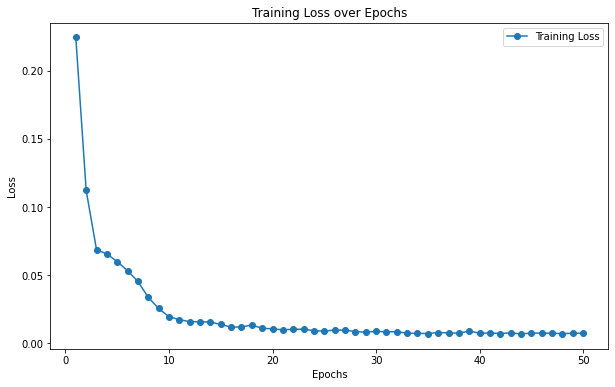

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

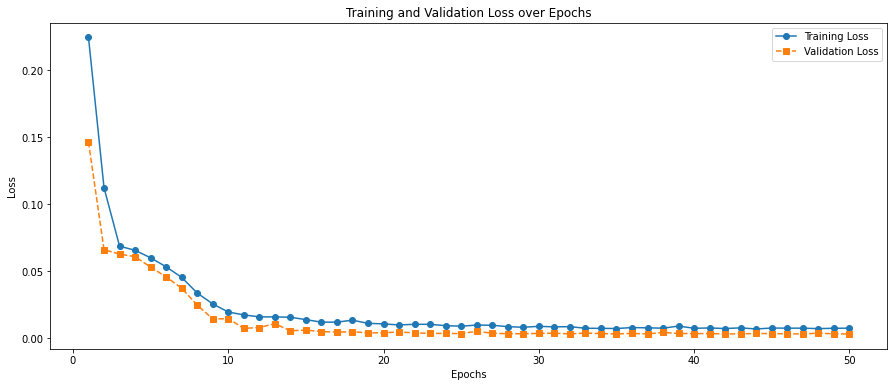

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 6ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0605484506046534
MAE : 0.04564562961871182


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0        1.407033e+05      61057.940
1        5.936946e+05     291275.949
2        9.240104e+05     678576.504
3        1.098551e+06     974461.347
4        1.226993e+06    1181121.087
5        1.257295e+06    1236299.254
6        1.120198e+06    1036981.003
7        8.836152e+05     847489.150
8        5.772977e+05     619129.338
9        2.977410e+05     195688.491
10       7.999409e+04      36670.811
11      -2.851429e+04      31777.310
12       9.727002e+04      82762.022
13       4.834178e+05     400043.823
14       7.729629e+05     733089.555
15       9.326952e+05     917362.266
16       1.066258e+06    1040584.040
17       1.157949e+06    1147997.675
18       1.102880e+06    1074255.327
19       8.708894e+05     875527.315
20       5.554289e+05     629820.756
21       2.832266e+05     204308.900
22       8.979619e+04      45059.062
23       2.278679e+04      33770.277
24       1.596365e+05      64135.631
25       4.891343e+05     400581.715
26       7.930134e+05     698631.451
27       9.503701e+05     973313.225
28       1.084988e+06    1335339.087
29       1.171781e+06    1429096.704
30       1.106489e+06    1206542.314
31       8.941393e+05    1079292.433
32       6.163177e+05     788101.638
33       3.314961e+05     397326.270
34       1.078050e+05      97802.348
35       1.302215e+04      62212.219
36       1.725665e+05     154051.600
37       5.208973e+05     610663.893
38       8.393434e+05     756679.164
39       1.028525e+06     962270.215
40       1.196291e+06    1235154.518
41       1.321479e+06    1161744.519
42       1.266339e+06    1136918.669
43       1.031399e+06     995852.026
44       7.228444e+05     781460.891
45       4.108486e+05     331845.048
46       1.662575e+05      99334.625
47       1.665152e+04      49359.723
48       1.077474e+05      85693.282

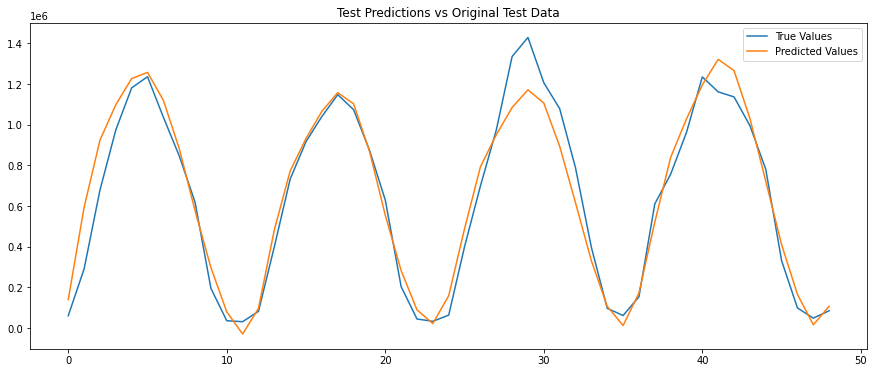

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

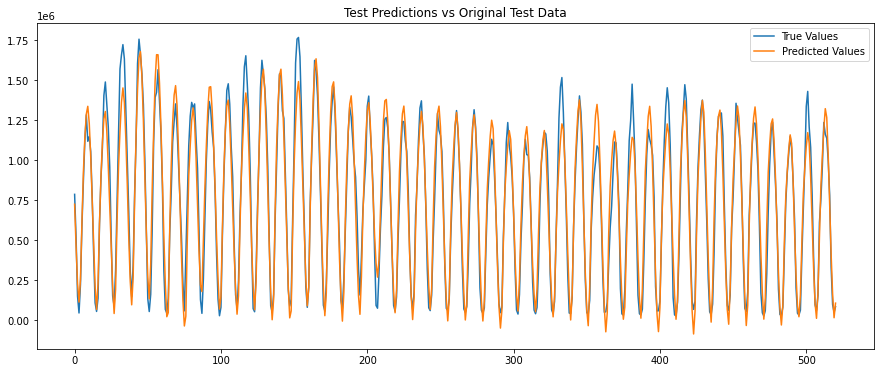

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()